In [15]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables

%matplotlib inline

In [2]:
SOTA2013_FIT = [0.18, 0.99, -0.49,  # Scale
                -1.49, 0.89, 0.28]  # Offset

In [3]:
if 'data_all' not in globals():
    with tables.openFile('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
        cols = h5.root.data.cols
        names = {'tstart': 'guide_tstart',
                 'obc_id': 'acqid',
                 'warm_pix': 'n100_warm_frac',
                 'mag': 'mag_aca',
                 'known_bad': 'known_bad'}
        acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                     names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately
    year = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
    quarter = (np.trunc((year - 1999.0) * 4)).astype('f4')
    fail = 1.0 - acqs['obc_id'].astype(np.int)
    warm_pix = acqs['warm_pix'].astype('f4')
    mag = acqs['mag'].astype('f4')

    t = Table([year, quarter, warm_pix, mag, fail],
              names=['year', 'quarter', 'warm_pix', 'mag', 'fail'])

    data_all = t.group_by('quarter')
    data_all['mag10'] = data_all['mag'] - 10.0
    data_all.sort('year')
    ok = (data_all['year'] > 2007) & (data_all['mag'] > 7.5) & (data_all['mag'] < 11.0)
    data_all = data_all[ok]
    data_all = data_all.group_by('quarter')
    data_mean = data_all.groups.aggregate(np.mean)

In [4]:
def scaled_warm_frac(pars, x, acq_data=None):
    if acq_data is None:
        acq_data = data_all  # use global data table
    scl0, scl1, scl2 = pars[0:3]
    off0, off1, off2 = pars[3:6]
    m = acq_data['mag10']
    scale = 10**(scl0 + scl1 * m + scl2 * m**2)
    offset = 10**(off0 + off1 * m + off2 * m**2)
    model_fail = offset + scale * (acq_data['warm_pix'] - 0.04)
    return model_fail

In [5]:
def fit_sota_model():
    from sherpa import ui

    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(scaled_warm_frac, 'model')
    ui.add_user_pars('model', ['scl0', 'scl1', 'scl2', 'off0', 'off1', 'off2'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data_all['year']), np.array(data_all['fail'], dtype=np.float))

    # Initial fit values from SOTA 2013 presentation (modulo typo there)
    start_vals = iter(SOTA2013_FIT)  # Offset
    fmod = ui.get_model_component('model')
    for name in ('scl', 'off'):
        for num in (0, 1, 2):
            comp_name = name + str(num)
            setattr(fmod, comp_name, start_vals.next())
            comp = getattr(fmod, comp_name)
            comp.min = -5
            comp.max = 5
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

In [6]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None):
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
    data = data_all[mask]
    data['model'] = scaled_warm_frac(pars, None, data)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    fail_sigmas = np.sqrt(data_mean['fail'] * len_groups) / len_groups
    
    plt.errorbar(data_mean[group_col], data_mean['fail'], yerr=fail_sigmas, fmt='.' + colors[0], label=label)
    plt.plot(data_mean[group_col], data_mean['model'], '-' + colors[1])
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [7]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [8]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [9]:
print('Hang tight, this will take a few minutes')
fit = fit_sota_model()

Starting fit - hang tight, this might take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 25250.7
Final fit statistic   = 25211.2 at function evaluation 6134
Data points           = 93620
Degrees of freedom    = 93614
Change in statistic   = 39.4979
   model.scl0     0.176393    
   model.scl1     1.04093     
   model.scl2     -0.326083   
   model.off0     -1.54804    
   model.off1     0.756808    
   model.off2     0.177263    


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 25250.7
Final fit statistic   = 25211.2 at function evaluation 6134
Data points           = 93620
Degrees of freedom    = 93614
Change in statistic   = 39.4979
   model.scl0     0.176393    
   model.scl1     1.04093     
   model.scl2     -0.326083   
   model.off0     -1.54804    
   model.off1     0.756808    
   model.off2     0.177263    


In [10]:
print(fit)

datasets       = (1,)
itermethodname = none
methodname     = neldermead
statname       = cash
succeeded      = True
parnames       = ('model.scl0', 'model.scl1', 'model.scl2', 'model.off0', 'model.off1', 'model.off2')
parvals        = (0.17639322406376071, 1.0409293524097623, -0.32608293825046963, -1.5480386444462495, 0.75680802646399592, 0.17726340874579569)
statval        = 25211.2342741
istatval       = 25250.7321431
dstatval       = 39.4978690409
numpoints      = 93620
dof            = 93614
qval           = None
rstat          = None
message        = Optimization terminated successfully
nfev           = 6134


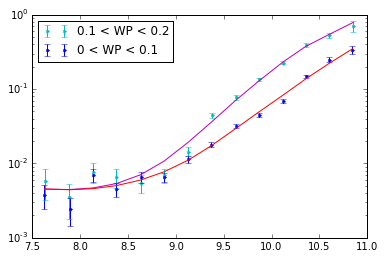

In [17]:
plot_fit_grouped(fit.parvals, 'mag', 0.25, wp_filter(0.10, 0.20), log=True, colors='cm', label='0.1 < WP < 0.2')
plot_fit_grouped(fit.parvals, 'mag', 0.25, wp_filter(0.0, 0.10), log=True, colors='br', label='0 < WP < 0.1')
plt.legend(loc='best');

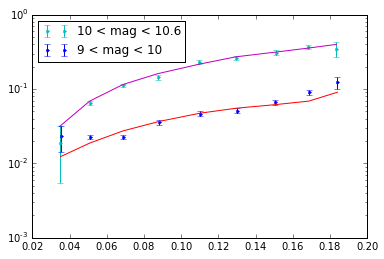

In [18]:
plot_fit_grouped(fit.parvals, 'warm_pix', 0.02, mag_filter(10, 10.6), log=True, colors='cm', label='10 < mag < 10.6')
plot_fit_grouped(fit.parvals, 'warm_pix', 0.02, mag_filter(9, 10), log=True, colors='br', label='9 < mag < 10')
plt.legend(loc='best');

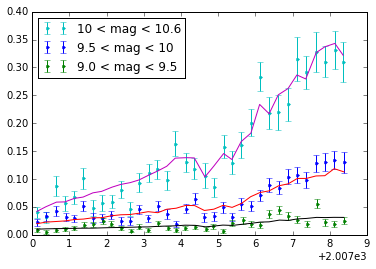

In [20]:
plot_fit_grouped(fit.parvals, 'year', 0.25, mag_filter(10, 10.6), colors='cm', label='10 < mag < 10.6')
plot_fit_grouped(fit.parvals, 'year', 0.25, mag_filter(9.5, 10), colors='br', label='9.5 < mag < 10')
plot_fit_grouped(fit.parvals, 'year', 0.25, mag_filter(9.0, 9.5),  colors='gk', label='9.0 < mag < 9.5')
plt.legend(loc='best');